### Simulation Investigation into Conditional Trend Filtering and Changepoint Detection on High-Frequency Price Process

Jason Bohne

Jason.bohne@stonybrook.edu

Applied Math and Stats Ph.D. Student 

Under Supervision of Professor Pawel Polak



In [1]:
import sys
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt


path='/home/jbohn/jupyter/personal/'
sys.path.append(f'{path}TAQ-Query-Scripts/data')
sys.path.append(f'{path}Adaptive_Signal_Estimation_Private')

from kernel_methods.Kernel_Smoother import KernelSmoother
from kernel_methods.MomKernel_Smoother import MomKernelSmoother
from trend_filtering.adaptive_tf_ir import adaptive_tf, Dmat, extract_cp, compute_lambda_max, cv_tf_penalty 
from dynamic_programming.dp_recursion import dp_solver
from dynamic_programming.cp_model_selection import generalized_cross_validation
from dynamic_programming.spline_fit import fit_linear_spline



from simulations.Conditional_Simulator import ConditionalSimulator

### Prep Data

- First minute seconds of trade data for AAPL after open across availble U.S. equity exchanges
- Benchmark model for seconds however can extend to any time interval
- Group observations by participant side timestamp; averaging price and summing volume
- Results in ~1400 observations
- Preprocessed and cleaned to remove trades executed before open

In [2]:
trades=pd.read_csv(f'{path}TAQ-Query-Scripts/data/cleaned_trades.csv',index_col=0).dropna()
trades=trades[trades.index < "2020-01-02 09:30:30"]
trades=trades[trades.index> "2020-01-02 09:30:00"]
trades.index=pd.to_datetime(trades.index)

# group same timestamp trades
trades['Index']=trades.index
#trades=trades.groupby('Index').agg({'Trade_Price':np.mean, 'Trade_Volume':np.sum})

trades['Trade_Price']=np.log(trades['Trade_Price'])

### Hyperparameters
- Number of Local Max; N
- Stationary Variance $\sigma^2$

Prior Series

In [3]:
N=150
variance=10e-5
sample_variance=0.005

### Step 1; Generate Prior and Smooth using KDE

- In our analysis trade volume will be used as a prior for changes in underlying price trend however any discrete series can be utilized (realized volatility)
- Normalize time of prior to be incremented in total seconds


Smoothing Technique (KDE)
- Nonparametric method which smooths candidate point $ x_i$ as a weighted average of all observations $x_j$ where weights $w_i$ are a function of their distance in time from candidate point
- Gaussian Kernels specify function of a normal density
- Optimal bandwidth is selected either through Scott's or Silvermans.

In [4]:
original_index=trades['Trade_Volume'].index
volume_index=[(i -original_index[0]).total_seconds() for i in original_index]
volume_prior=trades['Trade_Volume'].values

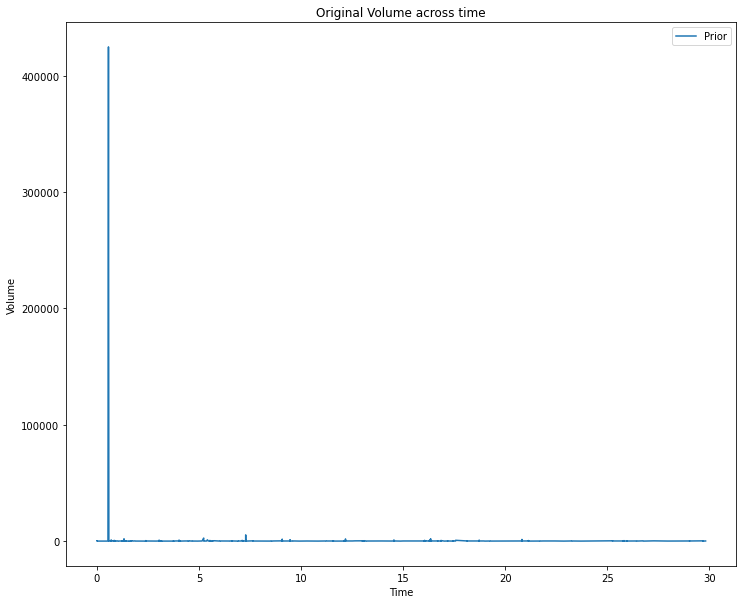

In [5]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original Volume across time")
plt.ylabel("Volume")
plt.xlabel("Time")
plt.plot(volume_index,volume_prior,label="Prior")
plt.legend()

In [6]:
from simulations.Conditional_Simulator import ConditionalSimulator

prior=volume_prior
sim_style='piecewise_constant'
label_style='k_maxima'
k_points=5
n_sims=10000
underling_dist='normal'

sim=ConditionalSimulator(prior[:50],sim_style,label_style,k_points,underling_dist,n_sims=n_sims)

In [7]:
import time

start=time.time()

true=sim.simulate()

end=time.time()
print(f"Simulation took {end-start} seconds")

Simulation took 0.016329288482666016 seconds


In [8]:
sim.cp_index

[0, 22, 23, 32, 34, 43, 49]

In [9]:
samples=sim.evaluate_within_sample(sim.cp_index,true)
samples

ValueError: operands could not be broadcast together with shapes (10000,) (10000,22) 

In [ ]:
samples[3,:]

array([-3.12954210e-04, -1.47947009e-03, -2.64598598e-03, -3.81250186e-03,
       -4.97901775e-03, -6.14553363e-03, -7.31204952e-03, -8.47856540e-03,
       -9.64508128e-03, -1.08115972e-02, -1.19781131e-02, -1.31446289e-02,
       -1.43111448e-02, -1.54776607e-02, -1.66441766e-02, -1.78106925e-02,
       -1.89772084e-02, -2.01437242e-02, -2.13102401e-02, -2.24767560e-02,
       -2.36432719e-02, -2.48097878e-02,  1.43078927e-03, -1.26297907e-03,
       -5.71431991e-03, -1.01656607e-02, -1.46170016e-02, -1.90683424e-02,
       -2.35196832e-02, -2.79710241e-02, -3.24223649e-02, -3.68737057e-02,
        1.93412993e-04,  7.47144765e-02, -2.27223899e-05, -8.41276338e-02,
       -1.68232545e-01, -2.52337457e-01, -3.36442368e-01, -4.20547279e-01,
       -5.04652191e-01, -5.88757102e-01, -6.72862014e-01, -6.70169567e-04,
        8.05155840e-01,  1.61098185e+00,  2.41680786e+00,  3.22263387e+00,
        4.02845988e+00,  4.87584016e-04])

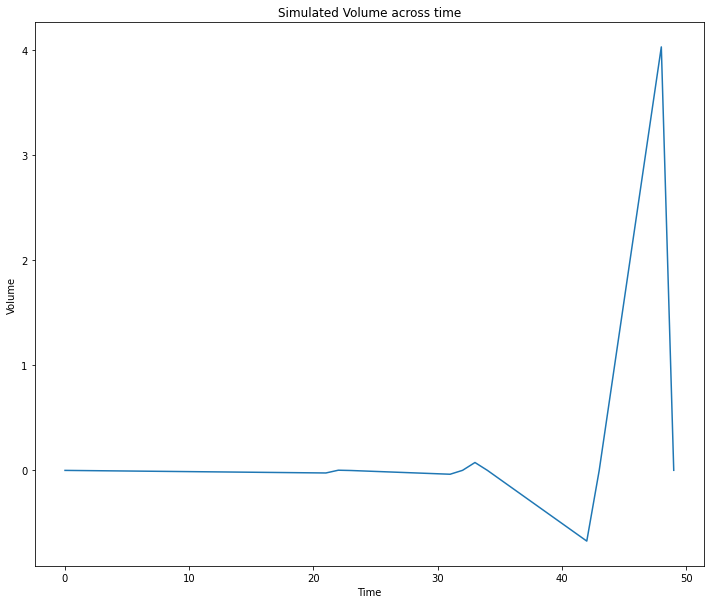

In [28]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Simulated Volume across time")
plt.ylabel("Volume")
plt.xlabel("Time")
#plt.plot(volume_index,samples[1,:],label="True")
plt.plot(samples[3,:],label="True")

In [6]:
smooth_kernel=KernelSmoother(volume_prior,volume_index,bandwidth_style=0)
smooth_kernel.fit()


In [7]:
smooth_kernel.smooth_series()

In [8]:
mom_smooth=MomKernelSmoother(smooth_kernel,N=10)
mom_smooth.fit_mom_kde()
mom_smooth.smooth_series()


[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165]), array([166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
    

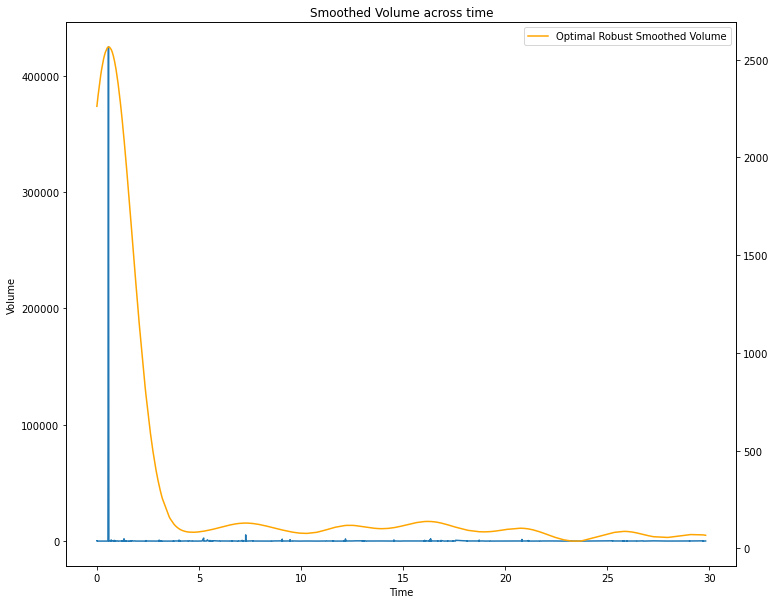

In [17]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Smoothed Volume across time")
plt.ylabel("Volume")
plt.xlabel("Time")
ax.plot(volume_index,volume_prior,label="Original")
ax2=ax.twinx()
ax2.plot(volume_index,smooth_kernel.smooth_prior,label="Optimal Smoothed Volume",color='orange')

ax2=ax.twinx()
ax2.plot(volume_index,mom_smooth.smooth_prior,label="Optimal Smoothed Volume",color='orange')
plt.legend()

### Step 2; Identify spikes in volume 
- Assumes changes in underlying trend occur within some d- neighborhood here
- Such that d is a hyperparameter prespecified

In [10]:
def remove_consecutive_max(indices,values,d):
 
    tuples=[(i,i+1) for i in range(0,len(indices))]

    diff_dict=dict(zip(tuples,np.diff(indices)))
    diff_list=sorted(diff_dict.items(),key=lambda x:x[1])
    list_indices=[i[0] for i in diff_list if i[1]<d]
    remove_indices=[i[np.argmin(np.array([values[i[0]-1],values[i[1]-1]]))] for i in list_indices]
    
    indices_to_keep=np.setdiff1d(np.arange(0,len(indices),1),remove_indices)
    
    return indices_to_keep


def find_max(prior,count,d=None):
    """ Find max n values of a series constrained to have certain distance d
    """
    
    if d is None:
        d=np.floor(0.01*len(prior))
        
    series=dict(zip(np.arange(0,len(prior)),prior))
    sorted_series=sorted( series.items(), key=lambda x:x[1],reverse=True)[:count]
    sorted_series=sorted(sorted_series, key=lambda x:x[0])
    
    indices=np.array([i[0] for i in sorted_series])
    values=np.array([i[1] for i in sorted_series])
    
    
    indices_to_keep=remove_consecutive_max(indices,values,d)
    
    new_indices=indices[indices_to_keep]
    new_values=values[indices_to_keep]
    
    return new_indices,new_values
    
indices,values=find_max(robust_smooth_volume,N)
indices

array([ 20, 516, 574, 579, 622, 748, 805])

### Step 3 ; Generate True Underlying Trend

- Given identified max values iterate forward at some linear rate
- Each change in underlying series is sampled from a normal distribution of variance prespecified 
- Interpretation is that most consecutive values will be piecewise linear with small noise; with sparse jumps arising from larger variance 


In [11]:
def generate_true_underlying(changepoints,variance,prior,prior_index=None,init=0,threshold=1,seed=1223224):
    """ Simulate price process as piecewise linear between selected changepoints; scaling distance btwn consecutive cp
    """
    np.random.seed(seed)
    if prior_index is None:
        prior_index=np.ones(len(prior))
    
    #soft thresholding to 1
    prior_index=np.fmax(prior_index,1)
    
    x0=0
    N=len(prior)
    samples=[]
    samples.append(x0)
    init_step=np.random.normal(loc=0,scale=variance,size=1)[0]
    
    samples.append(x0+init_step)
    prev_timestep=prior_index[0]
     
    for point in range(2,N):
        time_step=prior_index[point-1]
        mu=samples[point-1]+time_step*(samples[point-1]-samples[point-2]) # timesteps cancel out iteratively; better formulation numerically 
        
        # indicator function
        indicator=np.isin(point-1,changepoints).astype(int) # lagged cp
        scale=variance*indicator*time_step
        
        sample=mu+np.random.normal(loc=0,scale=scale,size=1)[0]
    
        samples.append(sample)
        prev_timestep=time_step
   

    return np.array(samples)+init

In [12]:
true_series=generate_true_underlying(indices,variance,volume_prior,init=50)

Text(0.5, 1.0, 'Simulated True Price Process')

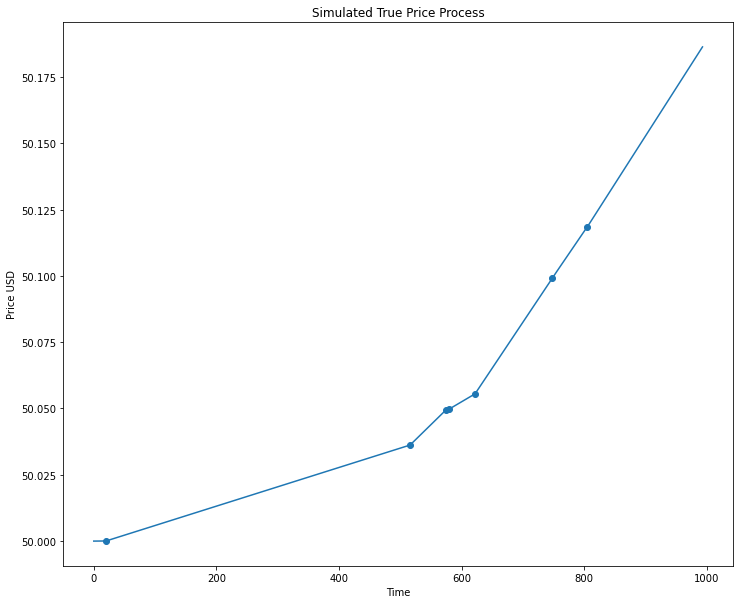

In [13]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(true_series)
plt.scatter(indices,true_series[indices])
plt.xlabel("Time")
plt.ylabel("Price USD")
plt.title("Simulated True Price Process")

### Step 4;  Generate normal sample of discrete process with centered locaiton parameters and prespecified variance parameter

In [14]:
def sample_discrete_process(true_series,sample_variance,seed=1223224):
    np.random.seed(seed)
    def generate_normal(mu,sample_variance):
        return np.random.normal (loc=mu,scale=sample_variance,size=1)[0]
    
    samples=[generate_normal(mu,sample_variance) for mu in true_series]
    
    return np.array(samples)

x_i=sample_discrete_process(true_series,sample_variance)

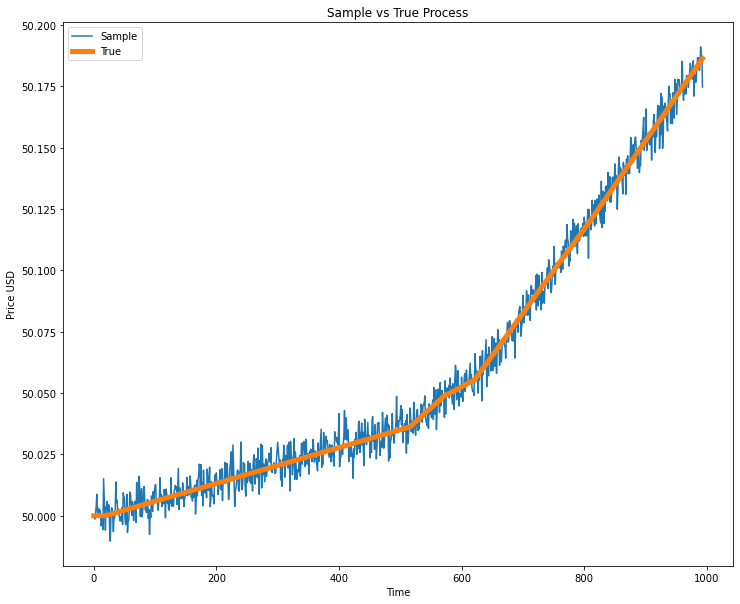

In [15]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(x_i,label='Sample')
plt.plot(true_series,label='True',lw=5)
plt.xlabel("Time")
plt.ylabel("Price USD")
plt.title("Sample vs True Process")
plt.legend()

### Numerical Results 1; L1 trend filtering 

- Given the simulated path from step 5; we wish to apply L1 trend filtering to the problem
- Incorporates irregular spacing between observations
- Constrains our estimator to be piecewise linear 
- Here the penalty is set to the optimal constant determined via cross validation
    - Some lambda values in cross validation do not lead to convergence 

In [16]:
lambda_max=compute_lambda_max(x_i,2)

lambda_grid=np.geomspace(0.001,lambda_max,20)

optimal_lambda,optimal_error=cv_tf_penalty(x_i.reshape(-1,1),volume_index,lambda_grid,verbose=False)

print(f"Optimal Lambda is {optimal_lambda} and Optimal Error is {optimal_error}")


maxiter exceeded
solved
pobj1: [[1.00330579e+10]], pobj2: [[0.0120117]], dobj: [[0.01192699]], gap: [[8.47109018e-05]]
solved
pobj1: [[1.23427816e+09]], pobj2: [[0.01229863]], dobj: [[0.01221992]], gap: [[7.87132798e-05]]
solved
pobj1: [[3.27915824e+08]], pobj2: [[0.01416629]], dobj: [[0.01412024]], gap: [[4.60468262e-05]]
solved
pobj1: [[2.40369515e+08]], pobj2: [[0.03019515]], dobj: [[0.03009879]], gap: [[9.63510868e-05]]
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
maxiter exceeded
Optimal Lambda is [1.01894335] and Optimal Error is [[[4.60468262e-05]]]


In [17]:
optimal_lambda

array([1.01894335])

In [18]:
trend_filter_series,status,gap=adaptive_tf(x_i.reshape(-1,1),t=volume_index,lambda_p=optimal_lambda)


pobj1: [[4.22978263e+08]], pobj2: [[477958.08972724]], dobj: [[0.]], gap: [[477958.08972724]]
pobj1: [[2.13962716e+10]], pobj2: [[0.02051049]], dobj: [[0.01207541]], gap: [[0.00843508]]
pobj1: [[2.81127554e+09]], pobj2: [[0.01431906]], dobj: [[0.01405099]], gap: [[0.00026807]]
solved
pobj1: [[3.27915824e+08]], pobj2: [[0.01416629]], dobj: [[0.01412024]], gap: [[4.60468262e-05]]


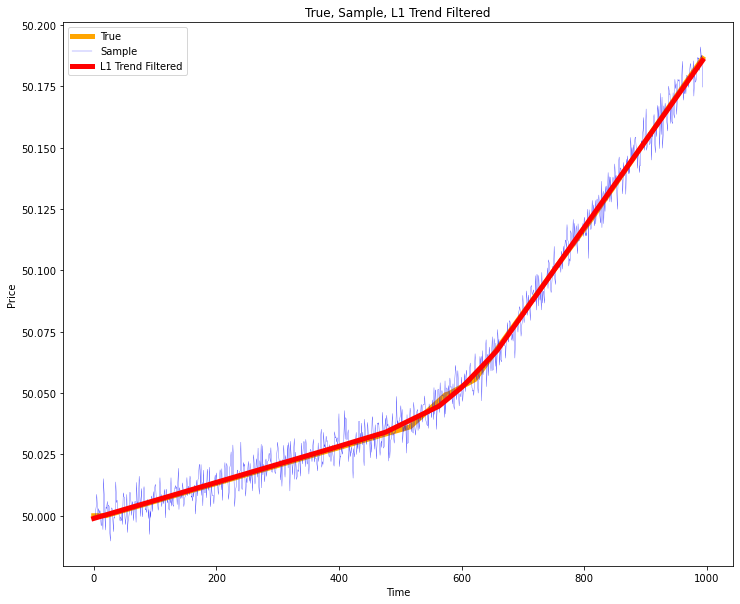

In [19]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(true_series,label='True', lw=5,color='orange')
plt.plot(x_i,label='Sample',color='blue',lw=0.25)
plt.plot(trend_filter_series,label='L1 Trend Filtered',lw=5,color='red')
plt.title("True, Sample, L1 Trend Filtered")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Numerical Result 1; Conditional Adaptive L1 trend filtering  
- Estimator is piecewise linear accounting for irregular observations
- Sensitivity of estimator to changes in underlying trend is conditional on inverse of prior 
- Included explicitly as adaptive penalty (scaled by scale_factor)

In [20]:
def compute_scale_factor(robust_smooth_volume,optimal_lambda):
    """ Compute scale factor for adaptive l1 trend filtering
    """

    mean_smooth_volume=np.mean(1/robust_smooth_volume)


    scale_factor=optimal_lambda/mean_smooth_volume

    
    return scale_factor



scale_factor=compute_scale_factor(robust_smooth_volume,optimal_lambda) 
print(f"Optimal Scale Factor is {scale_factor}") 
adaptive_trend_filter_series,status,gap=adaptive_tf(x_i.reshape(-1,1),t=volume_index,lambda_p=scale_factor*1/robust_smooth_volume[1:-1])
adaptive_trend_filter_series=adaptive_trend_filter_series.reshape(1,-1)[0][1:-1]

Optimal Scale Factor is [112.4481891]
pobj1: [[4.0244959e+08]], pobj2: [[404106.02856746]], dobj: [[0.]], gap: [[404106.02856746]]
pobj1: [[1.92849583e+11]], pobj2: [[0.01981197]], dobj: [[0.01194969]], gap: [[0.00786228]]
pobj1: [[3.07951039e+08]], pobj2: [[0.01284716]], dobj: [[0.01280104]], gap: [[4.61153638e-05]]
solved
pobj1: [[3.07951039e+08]], pobj2: [[0.01284716]], dobj: [[0.01280104]], gap: [[4.61153638e-05]]


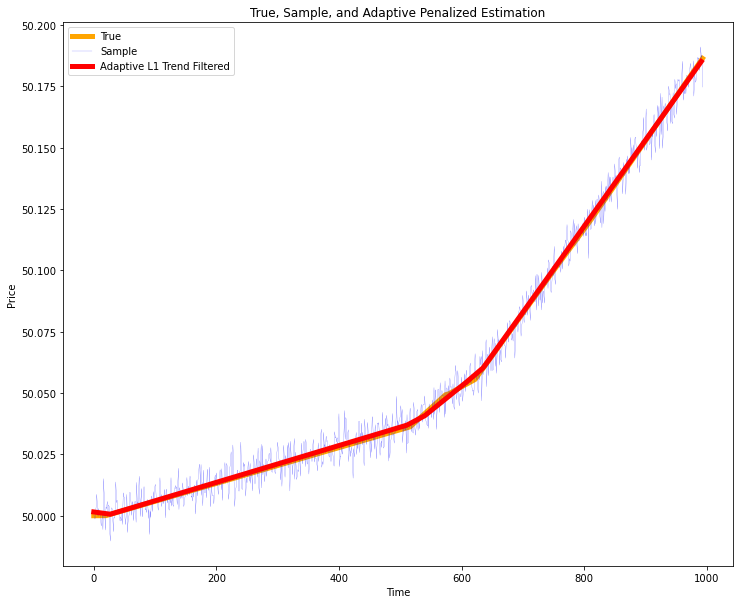

In [21]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(true_series,label='True', lw=5,color='orange')
plt.plot(x_i,label='Sample',color='blue',lw=0.15)
plt.plot(adaptive_trend_filter_series,label='Adaptive L1 Trend Filtered',lw=5,color='red')
plt.title("True, Sample, and Adaptive Penalized Estimation")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Step 7; Changepoint Extraction

- As estimator is piecweise linear; changepoints can be recovered in both simulations with second order difference operator
- Recovered changepoints plotted below; marked in black
- Threshold for occurrence of changepoint is another hyperparameter to be tuned

In [22]:
changepoints=extract_cp(trend_filter_series,threshold=1e-6)
adaptive_changepoints=extract_cp(adaptive_trend_filter_series,threshold=1e-6)

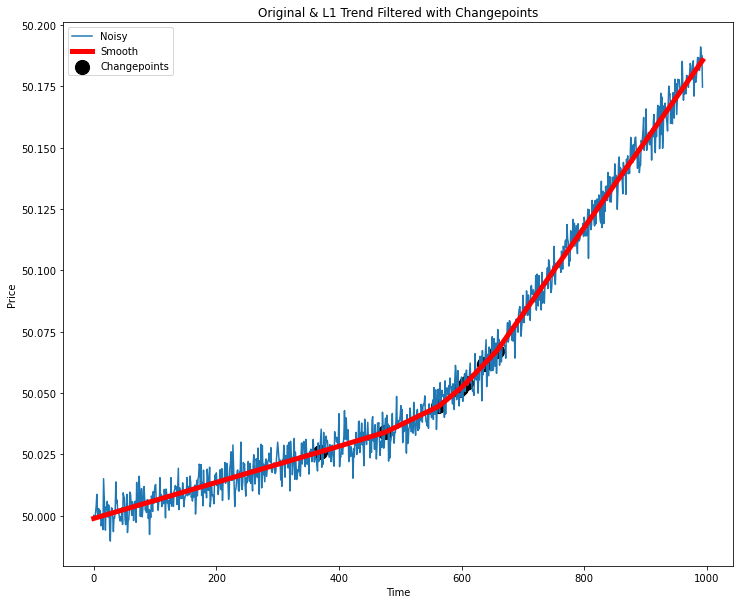

In [23]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(x_i,label='Noisy')
plt.plot(trend_filter_series,label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(x_i),1)[changepoints],trend_filter_series[changepoints],color='black',s=200,label='Changepoints')
plt.title("Original & L1 Trend Filtered with Changepoints")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

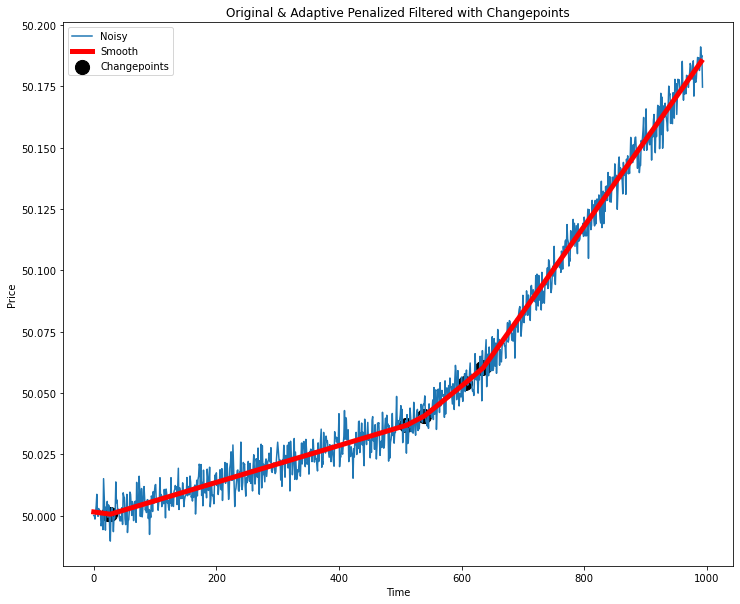

In [24]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(x_i,label='Noisy')
plt.plot(adaptive_trend_filter_series,label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(x_i),1)[adaptive_changepoints],adaptive_trend_filter_series[adaptive_changepoints],color='black',s=200,label='Changepoints')
plt.title("Original & Adaptive Penalized Filtered with Changepoints")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Pruning Candidate Set

- Given our candidate set utilize dynamic programming to recursively find optimal changepoints for fixed k_i


In [25]:
potential_trend_cp=dp_solver(x_i,changepoints,K_max=10)
potential_adaptive_trend_cp=dp_solver(x_i,adaptive_changepoints,K_max=3)
potential_trend_cp


K_max must be less than or equal to the number of candidate changepoints
Candidate Indices are [  0 369 475 562 596 599 607 637 657 994]
Candidate Indices are [  0  23  26 510 539 606 634 636 994]


{1: [596],
 2: [596, 599],
 3: [596, 599, 607],
 4: [562, 596, 599, 607],
 5: [562, 596, 599, 607, 637],
 6: [475, 562, 596, 599, 607, 637],
 7: [369, 475, 562, 596, 599, 607, 637],
 8: [369, 475, 562, 596, 599, 607, 637, 657],
 0: [0]}

### Model Selection
- Utilize GCV score to determine optimal model (scaled mse)

In [26]:
optimal_trend_cp_mse,optimal_trend_cp_gcv=generalized_cross_validation(x_i,potential_trend_cp)
optimal_adaptive_trend_cp_mse,optimal_adaptive_trend_cp_gcv=generalized_cross_validation(x_i,potential_adaptive_trend_cp)

opt_cp_1=potential_trend_cp[optimal_trend_cp_gcv[0][0]]
opt_cp_2=potential_adaptive_trend_cp[optimal_adaptive_trend_cp_gcv[0][0]]

print(f"Optimal Trend Changepoints are {opt_cp_1} with error {optimal_trend_cp_gcv[0][1]}")
print(f"Optimal Adaptive Trend Changepoints are  {opt_cp_2} with error {optimal_adaptive_trend_cp_gcv[0][1]}")

Optimal Trend Changepoints are [596] with error 5.257920192592592e-05
Optimal Adaptive Trend Changepoints are  [606] with error 5.291057742505125e-05


### Continuity Correction via Linear Splines
- Interpretation is that this is the best linear piecewise continuous estimator given our changepoints

In [27]:
optimal_lin_splines=fit_linear_spline(x_i,opt_cp_1)
optimal_adaptive_lin_splines=fit_linear_spline(x_i,opt_cp_2)


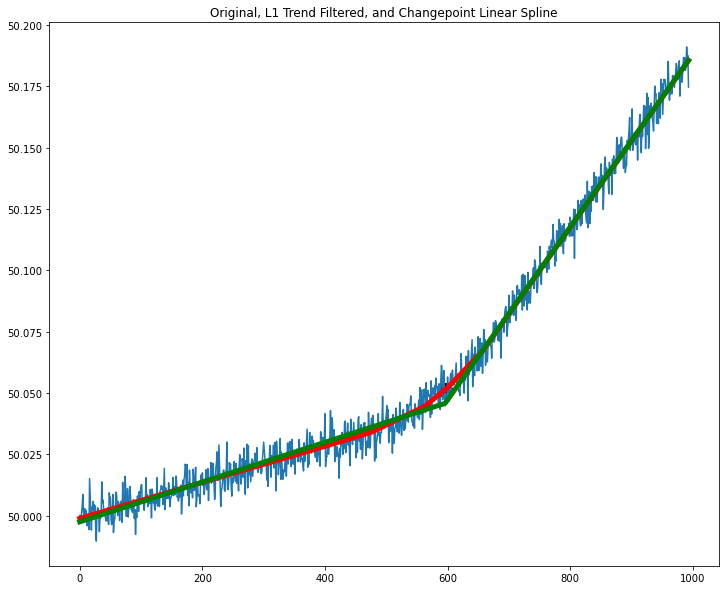

In [28]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original, L1 Trend Filtered, and Changepoint Linear Spline")
plt.plot(x_i,label='Noisy')
plt.plot(trend_filter_series,label='Smooth',lw=5,color='red')
plt.plot(optimal_lin_splines,label='Linear Spline',lw=5,color='green')
plt.scatter(np.arange(0,len(x_i),1)[opt_cp_1],trend_filter_series[opt_cp_1],color='black',s=200,label='Optimal Changepoints')

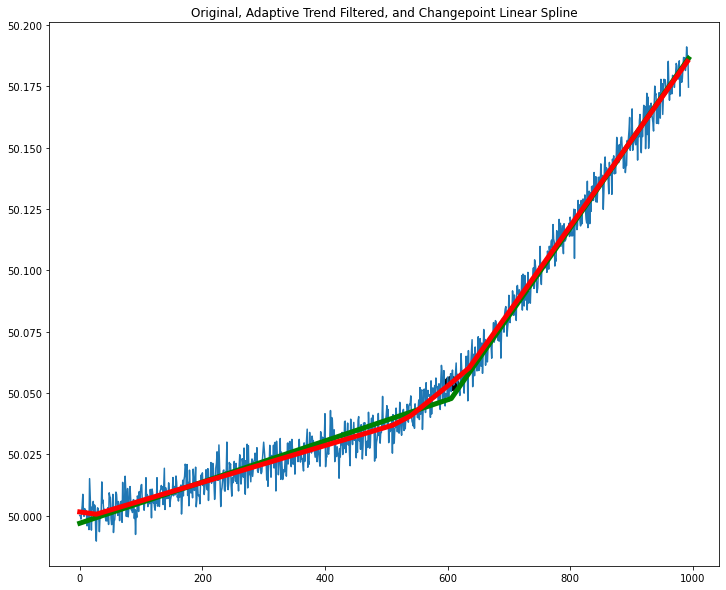

In [29]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original, Adaptive Trend Filtered, and Changepoint Linear Spline")
plt.plot(x_i,label='Noisy')
plt.plot(optimal_adaptive_lin_splines,label='Linear Spline',lw=5,color='green')
plt.plot(adaptive_trend_filter_series,label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(x_i),1)[opt_cp_2],adaptive_trend_filter_series[opt_cp_2],color='black',s=200,label='Optimal Changepoints')